# Magnitudes and focal mechanisms

This notebook covers three simple objectives:
1. Demonstrate instrument response removal and instrument simulation
2. Comparison of magnitude types
3. Simple focal mechanism fitting.

In [1]:
%matplotlib notebook

## Removing instrument response

You know that we can describe the effect of a seismograph's recording system as a series of linear filters. Thusfar we have worked solely with data in raw counts, as recorded by the seismograph, however, we often want to get real ground-motion amplitudes from our data. To do that we can remove the instrument response by deconvolving it from our recorded data.  We will use Obspy to correct for that instrument response and convert from *counts* to some physical unit in acceleration, velocity or displacement.

Lets look at what a broadband instrument ([JCZ](https://www.geonet.org.nz/data/network/sensor/JCZ)) looks like after Kaikoura in counts, displacement, velocity and acceleration.

First we will download the data and response information for that site:

C:\Users\Calum\miniconda3\envs\gphs445\lib\site-packages\obspy\io\stationxml\core.py:96: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "


<IPython.core.display.Javascript object>


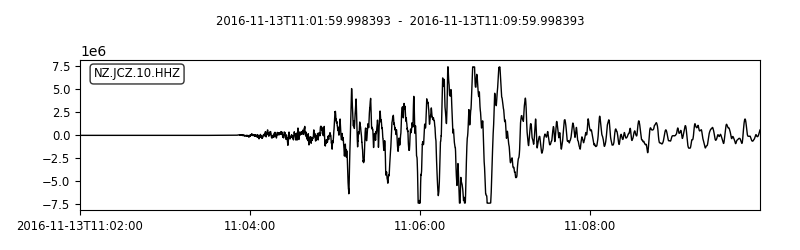

In [2]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime


client = Client("GEONET")
st = client.get_waveforms(
    network="NZ", station="JCZ", channel="HHZ", location="10",
    starttime=UTCDateTime(2016, 11, 13, 11, 2),
    endtime=UTCDateTime(2016, 11, 13, 11, 10))
inv = client.get_stations(
    network="NZ", station="JCZ", channel="HHZ", location="10",
    starttime=UTCDateTime(2016, 11, 13, 11, 2),
    endtime=UTCDateTime(2016, 11, 13, 11, 10),
    level="response")  # We need to set level=response to get the response info.

fig = st.plot(show=False, handle=True)

Because we are going to be working in the frequency domain, which assumes that our signals are periodic, we will first detrend and taper our data. **Don't forget to detrend!** You don't always need to taper, but you (almost) always need to detrend...

In [3]:
st = st.detrend().taper(0.05)

We can convert the stream from counts to ground motion using the `.remove_response()` method and specifying the `output` argument.  See the [remove_response docs](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html) for more options.  `remove_response` works in place on the data, so we will copy the stream first to ensure we can still access the original data.

First we can convert to and plot displacement:

<IPython.core.display.Javascript object>


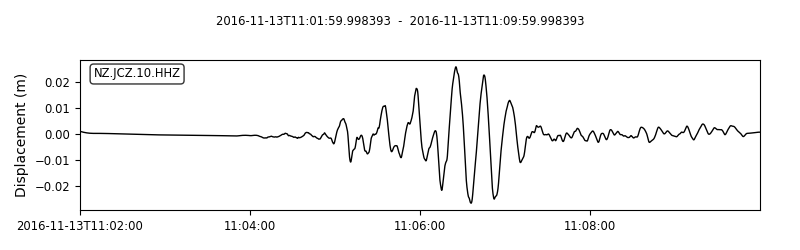

In [4]:
st_disp = st.copy().remove_response(inventory=inv, output="DISP")

fig = st_disp.plot(handle=True)
ax = fig.gca()
ax.set_ylabel("Displacement (m)")
fig.show()

And we can convert to velocity:

<IPython.core.display.Javascript object>


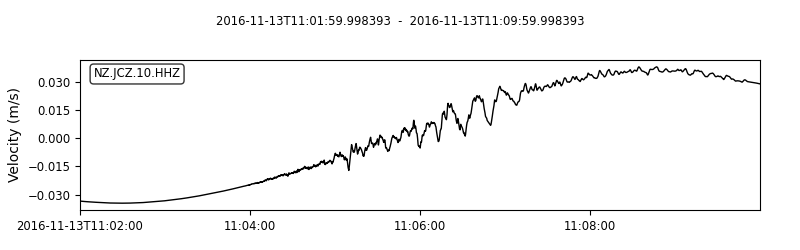

In [5]:
st_vel = st.copy().remove_response(inventory=inv, output="VEL")

fig = st_vel.plot(handle=True)
ax = fig.gca()
ax.set_ylabel("Velocity (m/s)")
fig.show()

And acceleration:

<IPython.core.display.Javascript object>


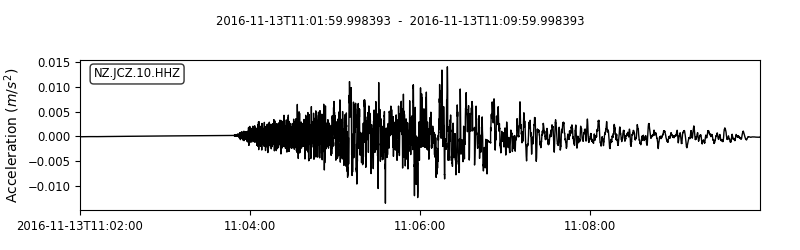

In [6]:
st_acc = st.copy().remove_response(inventory=inv, output="ACC")

fig = st_acc.plot(handle=True)
ax = fig.gca()
ax.set_ylabel("Acceleration ($m/s^2$)")
fig.show()

To understand the steps being taken during the instrument correction process Obspy's plot option when removing response can be instructive. Lets have a look at what is happening here:

<IPython.core.display.Javascript object>


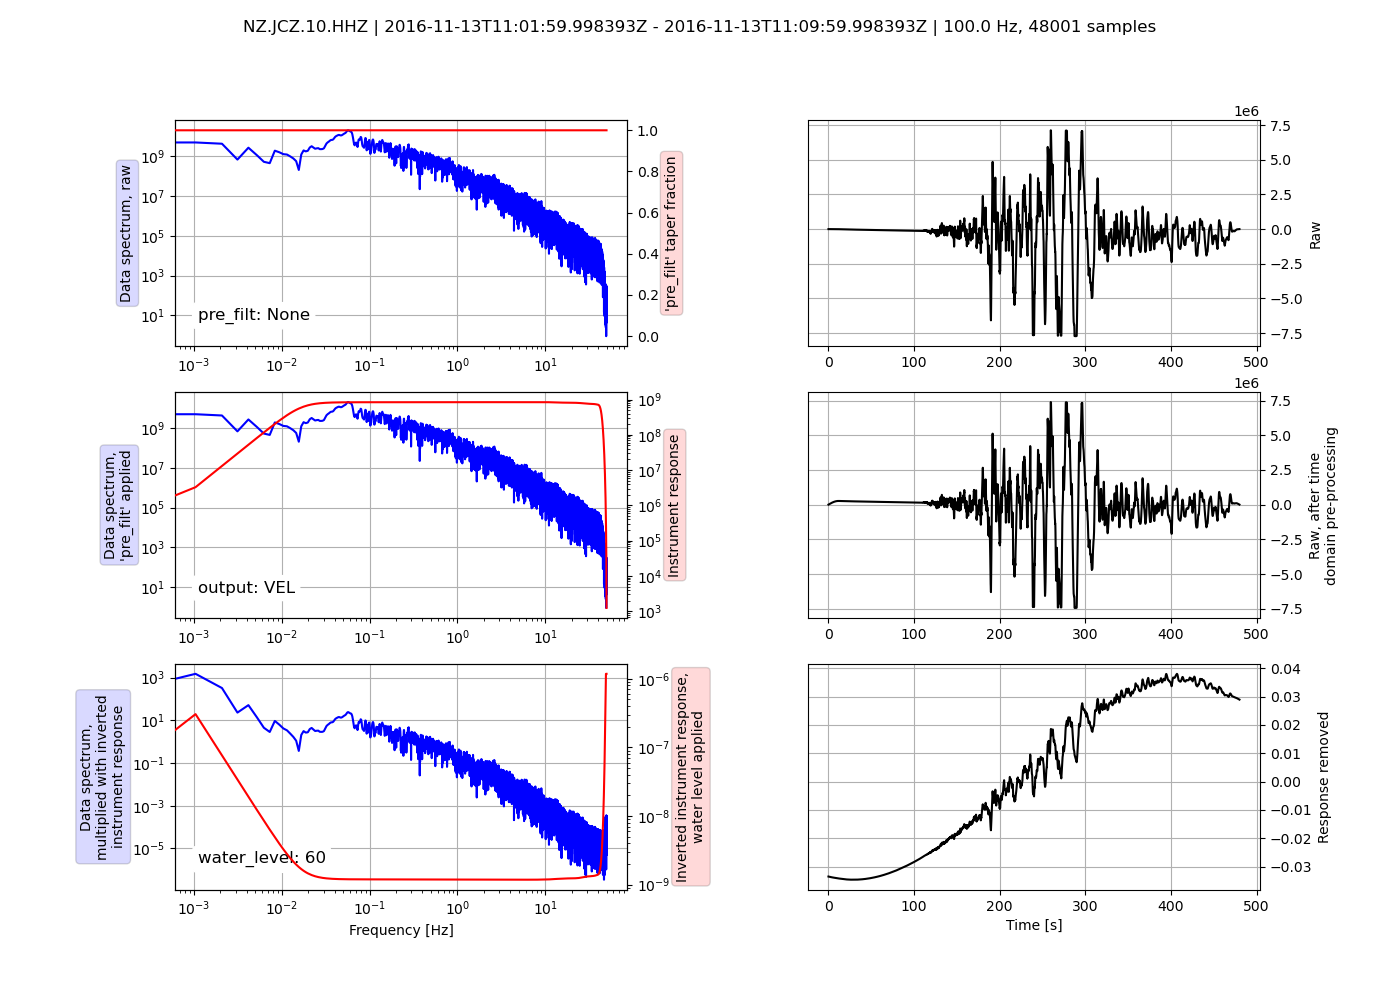

1 Trace(s) in Stream:
NZ.JCZ.10.HHZ | 2016-11-13T11:01:59.998393Z - 2016-11-13T11:09:59.998393Z | 100.0 Hz, 48001 samples

In [7]:
st.copy().remove_response(inventory=inv, output="VEL", plot=True)

This is showing us the main steps taken when removing the instrument response in the frequency domain (left) and time-domain. These steps are:
1. Pre-filter (we have selected none for this option),
2. Deconvolve instrument response (red line in frequency plot, row 2) - remember that deconvolution is division in the frequency domain - (although in ObsPy this is actually done as multiplication with one-over the instrument response.
3. Apply water-level.

Steps 1 and 3 are done to stabilise the process. The pre-filter can be used to make sure that unrealistic frequencies are not included. The water-level can be used to remove frequencies that have been over-gained in the division process due to numerical instabilities (remember that $\frac{x}{0} = \infty$, and that numbers close to zero may be mis-represented as zero due to numerical precision).

## Exercise:

Try downloading a strong-motion (channel codes starting with HN) and a short-period (channel codes starting with EH) site for Kaikoura and convert both of those to velocity as above with the plot on - how different do the instrument response and corrected data look?

For stations, try 
- WNPS, location=20, channels=HNZ (Wanaka)
- GCSZ, location=10, channels=EHZ (Gaunt Creek, DFDP 1)

In [8]:
# Your code here

---

# Magnitudes

We commonly describe an earthquakes size based on its magnitude. There are various magnitude scales in use, but all vary logarithmically. In a general sense, the energy released by a magnitude 2 earthquake is roughly ten times greater than a magnitude 1, but this varies with stress drop and shear modulus: energy is not simply related to magnitude... However, most magnitude scales are not related to energy even indirectly, only the moment magnitude ($M_W$) scale is tied indirectly to energy release.

In this notebook we will look at how the following magnitudes are calculated:
- Local Magnitude ($M_L$);
- Coda-duration Magnitude ($M_D$).

The theory behind most of this can be found in Section 4.6 of Stein and Wysession.  We are not going to cover moment magnitude calculation because this requires some additional knowledge of source process, however, for some information on a recent development in computing moment magnitudes, check out the W-phase moment magnitude method (which is now routinely in use by USGS for fast determination of large earthquake magnitudes), and the paper by [Duputel et al., 2012](https://academic.oup.com/gji/article/189/2/1125/621962).

For a list of other commonly used scales, see the [USGS table of magnitudes.](https://www.usgs.gov/programs/earthquake-hazards/magnitude-types)

## Local Magnitude

$M_L$ began life as the *Richter magnitude*, however, this is a magnitude scale with specific scaling parameters for Southern California. The same equation form used in the initial Richter scale is used elsewhere, but with appropriate attenuation parameters: if the original Southern California Richter scale is used in New Zealand it doesn't give the correct result (as well will see when we try to use it!).

$M_L$ is based on the measurement of the peak amplitude in a waveform recorded by a *Wood-Anderson* seismometer. There are very few Wood-Anderson seismometers still in operation today, but we know what the instrument response of a Wood-Anderson instrument is, and can therefore simulate Wood-Anderson waveforms from other instruments by correcting for the original instruments response (as above) and convolving the resulting ground motion with the response of a Wood-Anderson instrument.  

The original Richter local magnitude scale is:

\begin{equation*}
    M_L = \log{A} + 2.76\log{\Delta} - 2.48
\end{equation*}
where $A$ is the peak amplitude (in micro-meters) on a Wood-Anderson seismometer, $\Delta$ is the epicentral distance. This only works well for shallow earthquakes. The second term effectively corrects for geometrical spreading, while the final factor is included to scale the magnitude.

The adapted local magnitude scale for New Zealand is:
\begin{equation*}
    M_L = \log{A} + \log{\Delta} + 0.0029\Delta + S
\end{equation*}
where S is a station correction term. See [Ristau, 2009](https://pubs.geoscienceworld.org/ssa/bssa/article/99/3/1841/342119/comparison-of-magnitude-estimates-for-new-zealand) for a discussion of some of the magnitudes in use in New Zealand.

Recent work by [Michailos et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2018GC007743) derived a robust local magnitude scale for the Southern Alps tied to moment magnitude:

\begin{equation*}
    M_L = \log{A} + \log{r} + \eta r - S - 3.644
\end{equation*}
where $r$ is the hypocentral distance, $\eta$ is an attenuation parameter, which, for $r\le 60km$ is $1.2\times 10^{-2}km^{-1}$ and for $r>60km$ is $0.01\times 10^{-2}km{-1}$. $S$ is a site dependent correction which incorporates local site effects. Geometrical spreading is assumed to be logarithmically related to $r$, with a gradient of 1.

The reason that we end up with multiple magnitude scales is similar to the reason we need to include station correction terms: we don't do a good job of correcting for path effects. When the paths change, the geology the waves encounter is different and so the attenuation is different. Although we correct for some of the attenuation in the attenuation correction terms, these don't capture the 3D range of variability we see in the geology.  This is also part of the reason why we get different magnitude estimates from different stations (another major factor is that amplitudes vary with azimuth from the source, as well as directivity affects).

Lets look at how we would pick an amplitude for local magnitude for a nearby earthquake. We will use the `seismic_picker.py` applet again which has been extended to allow amplitude and duration picks to be made.

**TO MAKE THIS WORK YOU WILL NEED TO RESTART YOUR KERNEL (press the  button at the top of the screen) TO ALLOW POP UP WINDOWS**

In [1]:
%matplotlib
from obspy.clients.fdsn import Client
from gphs445_utilities.plot_event import get_geonet_waveforms

client = Client("GEONET")
event = client.get_events(eventid="2019p304574")[0]
# Lets just use the five closest weak motion stations
clean_event = event.copy()
clean_event.picks = [
    p for p in sorted(event.picks, key=lambda p: p.time) 
    if p.waveform_id.channel_code[0] != "B"][0:5]

# We want to remove the amplitudes already picked, and magnitudes so that we can overwrite them with our own.
clean_event.amplitudes = []
clean_event.station_magnitudes = []

st = get_geonet_waveforms(clean_event, all_components=True)
st = st.detrend().taper(0.05)
st.plot()  # For some reason on Windows I need to plot in this first cell to get later plots to work.
# We need to response information for the stations so that we can correct
# the repsonse and simulate a wood anderson instrument.
bulk = [
    (p.waveform_id.network_code, p.waveform_id.station_code, 
     p.waveform_id.location_code, p.waveform_id.channel_code[0:-1] + "?", 
     p.time - 60, p.time + 200) for p in clean_event.picks]
inv = client.get_stations_bulk(bulk, level="response")

Using matplotlib backend: <object object at 0x0000025506316130>


C:\Users\Calum\miniconda3\envs\gphs445\lib\site-packages\obspy\io\stationxml\core.py:96: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "


To pick local magnitudes we want to simulate a Wood-Anderson instrument.  To do this we can use obspy's 
[remove_response](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.remove_response.html#obspy.core.stream.Stream.remove_response)
and [simulate](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.simulate.html#obspy.core.stream.Stream.simulate) 
methods to remove the instrument response then apply the Wood-Anderson response.

In [2]:
paz_WA = {'poles': [-6.283 + 4.7124j, -6.283 - 4.7124j],
          'zeros': [0 + 0j], 'gain': 1.0, 'sensitivity': 2080}
st_wa = st.copy()
st_wa = st_wa.remove_response(inv, "DISP")
st_wa = st_wa.simulate(paz_remove=None, paz_simulate=paz_WA)

Run the picker. Amplitude picks for local magnitudes were originally defined as being picked on the
horizontals, however vertical channels are sometimes used because they are less succeptible to shallow amplification effects. Picks should be made at the maximum amplitude.  The picker will record your mouse position and add an `Amplitude` and a `Pick` for that position.

In [3]:
from gphs445_utilities.seismic_picker import SeismicPicker

event_out = SeismicPicker(st_wa, event_in=clean_event).pick()
print(event_out)

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button
Amplitude pick made at 2019-04-23T16:37:21.448199Z with amplitude 0.023
Amplitude pick made at 2019-04-23T16:37:24.738651Z with amplitude -0.013
Amplitude pick made at 2019-04-23T16:37:31.706668Z with amplitude 0.006
Amplitude pick made at 2019-04-23T16:37:31.513112Z with amplitude -0.025
Amplitude pick made at 2019-04-23T16:37:28.029104Z with amplitude -0.0066
Amplitude pick made at 2019-04-23T16:37:28.029104Z with amplitude -0.017
Amplitude pick made at 2019-04-23T16:37:22.415979Z with amplitude -0.0096
Finished picking.
Finished processing event. Returning
Returning event
Event:	2019-04-23T16:37:10.033368Z | -40.260, +175.967 | 4.790120006 

In [4]:
event_picked = event_out.copy()
# Quick plot to check that the picks are recorded in the right place
SeismicPicker(st_wa, event_picked).show()

Enetering non-interactive state.
Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button
Finished picking.
Finished processing event. Returning


In [5]:
for amplitude in event_picked.amplitudes:
    if amplitude.type != "END":
        print("Amplitude: {0:.2g} m".format(amplitude.generic_amplitude))

Amplitude: 0.023 m
Amplitude: -0.013 m
Amplitude: 0.006 m
Amplitude: -0.025 m
Amplitude: -0.0066 m
Amplitude: -0.017 m
Amplitude: -0.0096 m


We need to know where the earthquake was to calculate the hypocentral distance. We will use the `coordinates.py` classes to
estimate distance (using a flat earth approximation, so only good for local earthquakes).

In [6]:
from gphs445_utilities.location import Geographic
from math import log10

def _distance(point_1, point_2):
    """
    Calcuate hypocentral distance from Geographic points
    
    :type point_1: `coordinates.Geographic`
    :type point_2: `coordinates.Geographic`
    
    :returns: float
    """
    point_2_xyz = point_2.to_xyz(origin=point_1, strike=0, dip=90)
    return (point_2_xyz.x ** 2 + point_2_xyz.y ** 2 + point_2_xyz.z ** 2) ** 0.5

origin = clean_event.preferred_origin()
origin = Geographic(
    latitude=origin.latitude, longitude=origin.longitude, 
    depth=origin.depth / 1000.)
magnitude = 0
used_station_count = 0
for amplitude in event_picked.amplitudes:
    if amplitude.type == 'END':
        continue
    pick = amplitude.pick_id.get_referred_object()
    station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                      pick.time)
    station_loc = Geographic(
        latitude=station_loc["latitude"], longitude=station_loc["longitude"],
        depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
    distance = _distance(origin, station_loc)
    print("Amplitude {0:.2g} m at {1:.2f} km".format(
        amplitude.generic_amplitude, distance))
    station_magnitude = (
        log10(abs(amplitude.generic_amplitude) * 1e6) + log10(distance) - 
        0.0029 * distance + 0)
    print("Using the Richter scale gives: {0:.2f}".format(station_magnitude))
    magnitude += station_magnitude
    used_station_count += 1

if used_station_count == 0:
    print(f"No amplitude picks found")
else:
    magnitude /= used_station_count
    print("Average magnitude: {0:.2f}".format(magnitude))
    print("GeoNet magnitude: {0:.2f}".format(clean_event.preferred_magnitude().mag))

Amplitude 0.023 m at 30.59 km
Using the Richter scale gives: 5.76
Amplitude -0.013 m at 30.59 km
Using the Richter scale gives: 5.49
Amplitude 0.006 m at 50.14 km
Using the Richter scale gives: 5.33
Amplitude -0.025 m at 33.45 km
Using the Richter scale gives: 5.82
Amplitude -0.0066 m at 33.45 km
Using the Richter scale gives: 5.25
Amplitude -0.017 m at 41.18 km
Using the Richter scale gives: 5.72
Amplitude -0.0096 m at 41.18 km
Using the Richter scale gives: 5.48
Average magnitude: 5.55
GeoNet magnitude: 4.79


The magnitude I calculated is a little high, this is likely because we used attenuation parameters that are
not appropriate for the region of the Earthquake, and we have not included any station correction terms.
Another factor may be incorrect amplitude picks: it is common to pick amplitudes as half the peak-to-trough 
amplitudes to remove any bias due to dc-shifts in the data, but I haven't incorporated that into the picker yet.

Note that GeoNet report an *average* magnitude, based on multiple different magnitude estimates.  The local
magnitudes currently calculated by GeoNet are also slightly different in that they calculate $M_{Lv}$ magnitudes,
which do not correct to displacement waveforms, so the magnitude that they calculate is somewhat different to
the equation used above.  The main reason for computing $M_{Lv}$ is to avoid possible instabilities in the integration from velocity
seismograms to displacement.

## Exercise:

Repeat the above for a small magnitude (~M 2) earthquake somewhere in New Zealand.

In [7]:
# Your code here.

## Coda-duration Magnitude

Coda-duration magnitude is a simple and fast way of estimating local event magnitude, however this is not in use in New Zealand. Japan, California, Mexico, Italy and other places all have coda magnitude calculations, so we will select one of these magnitude-scales to compute coda-duration magnitudes.  The principle is to measure the time between the initial P-wave and the time that the seismogram drops below some noise threshold. How this is defined is different from place-to-place, and coda magnitudes are usually scaled to some other magnitude. See Page 70 of the [NMSOP, Chapter 3](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:108170:12/component/escidoc:364681/Chapter_3.pdf).

We will use the Mexican scale:
\begin{equation*}
    M_d = 2.40\log{d} + 0.00046\Delta - 1.59
\end{equation*}
where d is the duration in seconds.

Similar to amplitudes, shaking duration is strongly dependent on local geology and near-site amplification effects, so duration magnitude scales should be tuned for the region (and instrument!) in question.

You can add duration picks to channels with P-phase picks in the picker using the "e" key. Try to pick when the amplitudes drop back to roughly the pre-event noise level.

In [8]:
event_picked = SeismicPicker(st_wa, event_picked).pick()

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button
Duration end pick made at 2019-04-23T16:38:59.968217Z
Duration end pick made at 2019-04-23T16:38:53.000200Z
Finished picking.
No matching P for duration on NZ.DVHZ.10.EHN
No matching P for duration on NZ.PNHZ.10.EHE
Finished processing event. Returning
Returning event


In [9]:
magnitude = 0
used_station_count = 0
for amplitude in event_picked.amplitudes:
    if amplitude.type != 'END':
        continue
    pick = amplitude.pick_id.get_referred_object()
    station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                      pick.time)
    station_loc = Geographic(
        latitude=station_loc["latitude"], longitude=station_loc["longitude"],
        depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
    distance = _distance(origin, station_loc)
    print("Duration {0:.2g} s at {1:.2f} km".format(
        amplitude.generic_amplitude, distance))
    station_magnitude = (
        2.4 * log10(amplitude.generic_amplitude) + 0.00046 * distance - 1.59)
    print("Using the Mexican Md scale gives: {0}".format(station_magnitude))
    magnitude += station_magnitude
    used_station_count += 1

if used_station_count == 0:
    print("No duration picks found")
else:
    magnitude /= used_station_count
    print("Average magnitude: {0}".format(magnitude))
    print("GeoNet magnitude: {0}".format(clean_event.preferred_magnitude().mag))

No duration picks found


When I do this my magnitude is clearly too low, which suggests that the coda duration is poorly picked, or/and that the Mexican magnitude scale is not appropriate for New Zealand. 

Hopefully you can see that the measurements for both amplitude and duration based magnitude scales could fairly easily be automated, and this is generally the case. Both maximum amplitude and duration are fairly simple to code, but both can be prone to issues with overlapping events. As ever, manual intervention and checking is very useful, so knowing what to look for is key!

## Exercise

Pick coda-duration magnitude for your chosen small earthquake from before.

In [10]:
# Your code here.

---
# Focal Mechanisms and Moment Tensors

Focal mechanisms describe slip on a fault arising from a purely double couple source. See Stein and Wysession's Section 4.4 for a discussion of force couples and single forces. Focal mechanisms inherently have ambiguity over which of the two resolved planes is the actual fault plane, and in general additional evidence is required to determine which plane is the fault plane. Focal mechanisms are commonly used to describe the faulting styles in a region, and to invert for principle stress axes orientations. 

Understanding stress orientations (and magnitude, which cannot be derived from focal mechanism inversion) is becoming useful for understanding the likelihood of induced earthquakes (e.g.: 
[Lund Snee and Zoback 2018](https://pubs.geoscienceworld.org/tle/article/37/2/127/527282/state-of-stress-in-the-permian-basin-texas-and-new)) and for understanding how stresses change around slow-slip events (e.g. [Warren-Smith et al., 2019](https://www.nature.com/articles/s41561-019-0367-x)) amongst other applications.

## First motions

The simplest and most widely used method for estimating focal mechanisms is to use the first-motion polarities of P-waves to determine which quadrant of the focal sphere a station lies in. The `seismic_picker.py` applet has been extended to allow you to pick polarities. Note that this needs to be the first motion polarity, **not** the polarity of the maximum peak. The wavetrain of an individual seismic phase is a superposition of different ray-paths, which may be of opposite polarities.  Polarities are either compressional (up) or dilatational (down). Waves that show compressive first motions arise when the faults first motion is towards the seismometer (along the ray-path, which may take an *interesting* path to the seismometer). Dilatational waves arise when the faults first motion is away from the seismometer.

<img alt="Stein and Wysession Fig 4.2-4" align="centre" style="width:40%" src="http://levee.wustl.edu/seismology/book/chapter4/chap4_sr/4_2_04_s.jpg">

Once polarities are measured they can be plotted on a stereonet with the position based on the take-off angle and back azimuth of the ray between the source and the receiver to obtain a scatter of points on the focal sphere. These points can be inverted to obtain a best fitting focal mechanism. Some important things to note are:
1. First motion amplitudes tend to zero towards the nodal planes thus polarities may be obscured close to nodal planes and be impossible to reliably pick;
2. Polarities are plotted based on take-off angle and azimuth. Both properties require accurate hypocentre locations and accurate ray-tracing;
3. Lower-hemisphere stereonets are commonly used because take-off angles for first arriving rays are often downwards (towards a faster medium).
   
To construct a focal mechanism we need polarity readings, as well as back azimuths and takeoff angles of rays. Sadly it doesn't look like GeoNet shares the takeoff angles for their events, so we are going to work with a catalogue of events that I re-located in NonLinLoc using the NZ wide 3D velocity model from [Eberhart-Phillips et al.](https://zenodo.org/record/3779523#.YGT_KBLRVhE)

You will pick polarities of an event in this catalogue, then try to fit a focal mechanism to those polarities!

In [ ]:
%matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from gphs445_utilities.seismic_picker import SeismicPicker
from gphs445_utilities.plot_event import get_geonet_waveforms

from obspy import read_events

cat = read_events("NLL_located.xml")  # You need to point this towards the file you download from Blackboard.

event = cat[0]
print("Event has {0} picks".format(len(event.picks)))
# We will remove the picks from strong motion sites, I don't know whether they are all wired the same way
event.picks = [p for p in event.picks 
               if p.waveform_id.location_code != "20"]

# Lets just look at the first 20 P-picks - we need to remove duplicate picks to do this.
event.picks.sort(key=lambda p: p.time)
_picks, stations = [], []
for p in event.picks:
    if len(_picks) == 20:
        break
    elif p.phase_hint == "P" and p.waveform_id.station_code not in stations:
        # We need to check that this station has a real arrival computed
        arr = [a for a in (event.preferred_origin() or event.origins[0]).arrivals 
               if a.pick_id.get_referred_object() == p]
        if len(arr) == 0:
            continue
        if arr[0].distance == 0:
            continue
        _picks.append(p)
        stations.append(p.waveform_id.station_code)
event.picks = _picks

st = get_geonet_waveforms(event=event, all_components=True)

Using matplotlib backend: QtAgg
Event has 125 picks


Now that we have some data, lets pick the polarities. A key thing to remember is: *if you can't reliably pick the polarity, then do not pick the polarity!*.

You will probably have to zoom in around the P-pick to see the polarity - remember that we are looking for the polarity of the first arriving wave - this may be quite a small bump!

In [ ]:
# We will add polarities to this GeoNet event.
picked_event = SeismicPicker(st.select(component="Z"), event_in=event).pick()

Now that we have polarities, we can use the take-off angles and azimuth calculated by GeoNet to plot our polarities on the focal sphere. Note that `event.origins[n].arrivals` contains the takeoff angle and azimuth information we need.

We are going to use a simple focal-mechanism viewer that I coded that will allow us to find a set of nodal planes that fit our data. In practice we would usually invert for these planes, but for teaching purposes I find it instructive to get you to try and fit them yourself. The inversion process is a simple grid-search method, where you test how well various sets of nodal planes fit your data and select the best fitting set. There are lots of methods for doing this, and for obtaining uncertainties. One interesting one is [MTFit](https://djpugh.github.io/MTfit/index.html) which computes the best fit moment tensor based on Bayesian statistics, and allows for amplitude ratios to be included.  Finn Ilsley-Kemp has been using this recently to good effect when looking at [volcanic earthquakes](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021GC009803).

We can now try and plot this and fit the planes ourselves. to adjust the planes, move the sliders at the bottom of the following plot. Things to remember when fitting these planes:
1. Planes should separate positive and negative polarities!
2. I find it easier to get one plane close to where I think it should be, then fry and fit the second.
3. The sign of the rake (positive or negative) must be the same for both nodal planes.
4. I find it easier to get somewhere near in strike, then adjust the dip and strike together so that the second nodal plane intersects the pole to the first nodal plane, then adjust the rake last.

The planes **must be orthogonal to one-another**: orthogonal planes are constrained such that the slip-vector of one-plane is the normal to the other. In this plot that means that the pole to nodal-plane 1 must align with the rake of nodal-plane 2 (and vice-versa).

In [14]:
import warnings
from gphs445_utilities.focal_mechanisms import FocalMechanism

fm = FocalMechanism.from_event(picked_event)
with warnings.catch_warnings():
    # the stereonet transform raises some warnings that we don't need to worry about
    warnings.simplefilter("ignore")
    fm.find_planes(show=True)

Found polarity of undecidable for NZ.BHW.10.HHZ
Found polarity of undecidable for NZ.CAW.10.EHZ
Found polarity of undecidable for NZ.DSZ.10.HHZ
Found polarity of undecidable for NZ.DUWZ.10.EHZ
Found polarity of undecidable for NZ.GVZ.10.HHZ
Found polarity of undecidable for NZ.KHZ.10.HHZ
Found polarity of undecidable for NZ.KIW.10.EHZ
Found polarity of undecidable for NZ.LTZ.10.HHZ
Found polarity of undecidable for NZ.MQZ.10.HHZ
Found polarity of undecidable for NZ.MRNZ.10.EHZ
Found polarity of undecidable for NZ.MTW.10.EHZ
Found polarity of undecidable for NZ.NNZ.10.HHZ
Found polarity of undecidable for NZ.OGWZ.10.EHZ
Found polarity of undecidable for NZ.TCW.10.EHZ
Found polarity of undecidable for NZ.THZ.10.HHZ
Found polarity of undecidable for NZ.TKNZ.10.EHZ
Found polarity of undecidable for NZ.TUWZ.10.EHZ
Found polarity of undecidable for NZ.WEL.10.HHZ


Write down your best fitting nodal planes, then try another event (change the index in the brackets - there are only about 20 events in this catalogue, and some of them don't have many arrivals, so you might not be able to make focal mechanisms for them all!).

<img alt="Stein and Wysession Fig 4.2-7" align="right" style="width:50%" src="http://levee.wustl.edu/seismology/book/chapter4/chap4_sr/4_2_07_s.jpg">

## Amplitude ratios

A simple extension of the first motion method is to take advantage of the difference in P and S-wave radiation patterns (see figure).

By taking the ratio of P and S wave amplitudes we can estimate where on the focal sphere we are. This provides additional information
to better constrain the focal mechanism, and can be especially useful near the nodal planes, where S amplitude is maximized but first
motion polarities of P waves can be hard to pick. We won't make use of this in your assignment, but you should read Stein and Wysession 4.2.3.

Focal mechanisms can also be estimated by modelling body or/and surface waves, see Stein and Wysession 4.3.

## Moment tensor inversion

So far we have just considered the information relating to simple slip on a single fault, however, natural events are often more complicated. At relatively low sampling
frequencies and large station-reciever distances, the high frequencies that show this complexity are lost, however, for larger events the complexity is manifest at
lower frequencies, meaning that we can resolve some of these complexities using seismic data. One way to resolve some of the complexity is to compute moment tensors.

Read Stein and Wysession 4.4 on moment tensors.  For some information on how moment tensors are routinely computed for earthquakes in New Zealand,
read [Ristau 2008](https://pubs.geoscienceworld.org/ssa/srl/article/79/3/400/367690/implementation-of-routine-regional-moment-tensor).  The
moment tensors are available via the [GeoNet github page](https://github.com/GeoNet/data/tree/master/moment-tensor). You should select some
moment tensors from the GeoNet dataset to answer the "Slip Parameters" question in the assignment.